# Project 2: Comparison of Localized Linear Regression (Loess) and Random Forest Regression on Boston Home Pricing, and Atomobile Efficiency Datasets



## Abstract

In this paper I compare the effectiveness of Localized Linear Regressions (loess) and Random Forests when applied to boston housing prices and automobile efficiency datasets. This implementation of loess used the tricubic kernal function, and a less robust method of regression than is standard in industry and academic research. Discussions include the datasets, the models and kfold validation technique, and the results. Finally, I found that for both datasets, loess outperformed random forest regressions.

Considerations with these results include that they are restricted to the range of the data provided, that they were trained on very small datasets, and training was restricted to one feature. To improve on these results one could use more data, more features, and use optimization methods on hyperparameters during training.

## The Data

These data sets are both quite small, and we are using them as two dimensional. For the boston housing data, we have selected the 'cmedv', or the median sale price per zipcode, as our target and the number of rooms in a given house as our one feature. For the 'cars' dataset, we've selected the miles-per-gallon of each car as the target, and the weight (in lbs) as the feature. Below are scatter plots of the data. clearly, neither is a very good candidate for a regular linear regression. The cars dataset is clearly polynomial of some-sort, and the housing data is too variable near the bottom and top range of both price and number of rooms.

I did very little preprocessing on this data. It came quite well curated, so the only thing I needed to do was scale the features, for which I used scikitlearn's StandardScalar, and do a train test split (75% train, 25% test).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata
from scipy import linalg
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler as ss

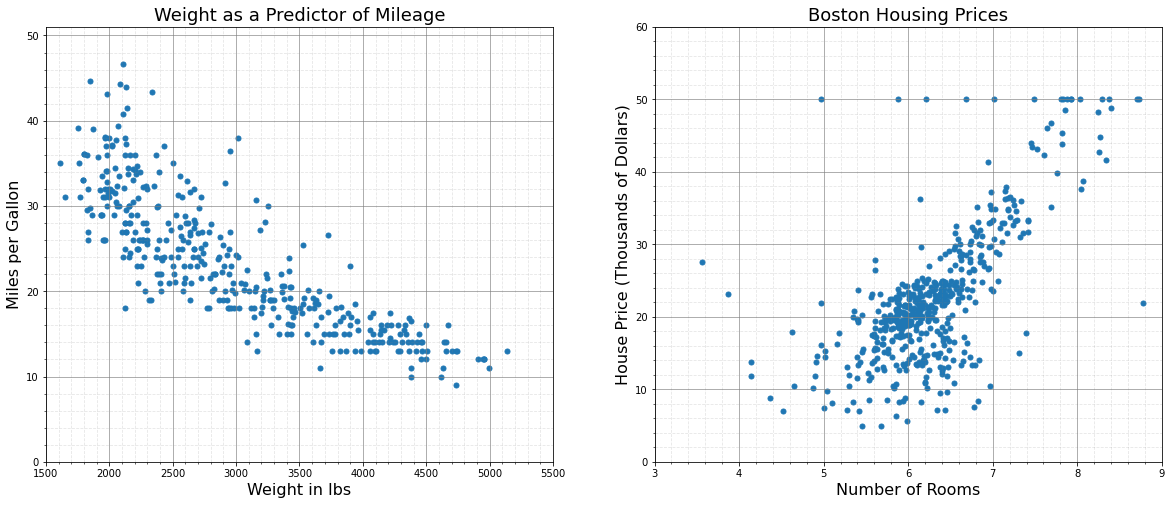

In [2]:
data = pd.read_csv("Data/cars.csv")

data_housing = pd.read_csv('Data/Boston_Housing_Prices.csv')
data_housing = data_housing[['cmedv', 'rooms']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1.set_xlim(1500, 5500)
ax1.set_ylim(0, 51)
ax1.scatter(x=data['WGT'], y=data['MPG'],s=25)
ax1.set_xlabel('Weight in lbs',fontsize=16)
ax1.set_ylabel('Miles per Gallon',fontsize=16)
ax1.set_title('Weight as a Predictor of Mileage',fontsize=18)
ax1.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax1.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax1.minorticks_on()

ax2.set_xlim(3, 9)
ax2.set_ylim(0, 60)
ax2.scatter(x=data_housing['rooms'], y=data_housing['cmedv'],s=25)
ax2.set_xlabel('Number of Rooms',fontsize=16)
ax2.set_ylabel('House Price (Thousands of Dollars)',fontsize=16)
ax2.set_title('Boston Housing Prices',fontsize=18)
ax2.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax2.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax2.minorticks_on()

plt.show()

In [3]:
x = data['WGT'].values
y = data['MPG'].values

scaler = ss()

xtrain, xtest, ytrain, ytest = tts(x,y, train_size = 0.75, random_state = 123)

xtrain_scaled = scaler.fit_transform(xtrain.reshape(-1, 1))
xtest_scaled = scaler.transform(xtest.reshape(-1, 1)) #Not fit tranform for the xtest

xtrain_scaled = xtrain_scaled.flatten()
xtest_scaled = xtest_scaled.flatten()

## The Models

### Loess
In this project I am comparing Localized Linear Regression (Loess) and Random Forest Regressions. Firstly, Loess is an improved version of a regular linear regression. Loess applies many short, local linear regressions throughout the data to maximize it's accuracy in that locality of the data. Loess also uses a kernal or 'bump' function to weight the value of datapoints in each local region of regression. The algebraic expression of the basic Loess function is:

$$\large W_{i}y = W_{i}X\cdot\beta +\sigma W_{i}\epsilon $$

Where capital letters represent matricies, and lowercase represent column vectors. We solve the above equation for the parameter $\beta$, while $W_i$ is the matrix of weights assigned to each row of X (observation of the data). The sum fo epsilon represents noise and is assumed to be normal, so we can eliminate it by taking the average and end with:

$$\large \bar{\beta} = (X^TX)^{-1}(X^Ty)$$

$$\large \hat{y} = X(X^TW_{i}X)^{-1}(X^TW_{i}y)$$

Where $\bar{\beta}$ are the expected value of $\beta$ and are the actual coefficients we will use, and the $\hat{y}$ are teh predictions. Note that this can be thought of as building predictions as linear combinatinos of the inputs and their known outputs

### Random Forests
Secondly, the Random Forest method is a leading regressor in industry application. It is resistant to overfitting, robustly designed, and relatively simple to conceptualize compared to other leading methods like Neural Networks. Random forests operate by creating many decision tree classifiers, which, after being trained, predict the target classifcation of a datapoint by "splitting" on a criteria that maximizes the "distance" between out comes of a decision. The random forest is special in it's effectiveness because it creates many trees that are only able to train on a subset of a features which are then sampled randomly (with replacement).

There are advantages and disadvantages to both of these methods. For Loess, advantages are the small number of parameters that need to be determined during training (one matrix of weights for each datapoint) and only two hyperparameters, width of locality and the choice of bump function. These features make loess faster to train, simpler to understand, adn less resource intense than random forests. The main disadvantage is that while it is never good to try to predict data outside the ranges of training data, Loess is particularly bad at this.

For random forests the disadvantages stand out for this data more than the advantages. This data is small, and there is only one feature. This means the relative resource intesnity of Random Forests makes it slower, and unnecessarily complex. However, as this data scales up, random forest would likely become a better option. With more entries and more features, random forests would be able to use it's random sampling of features to prevent overfitting. More data and features would also justify the resource intensity of random forests, which would allow for more optimization of hyperparameters and likely better models.

In [4]:
# Tricubic Kernel
def tricubic(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2, axis=1))
  return np.where(d>1,0,70/81*(1-d**3)**3)

def lowess_reg(x, y, xnew, kern, tau): #xnew is test data, x is input train data, y is output train data
    # tau is called bandwidth K((x-x[i])/(2*tau))
    # IMPORTANT: we expect x to the sorted increasingly
    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the bell shape kernel function    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        #theta = linalg.solve(A, b) # A*theta = b
        theta, res, rnk, s = linalg.lstsq(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 
    f = interp1d(x, yest,fill_value='extrapolate')
    return f(xnew)

Above is the function definition for the tricubic kernal function ($(1 - x^3)^3$), which is the one used in these Loess regressions. Above is also the function definition for the Loess regressor.

[Text(418.5, 475.65000000000003, 'X[0] <= -0.227\nmse = 61.568\nsamples = 193\nvalue = 23.986'),
 Text(209.25, 339.75, 'X[0] <= -0.869\nmse = 29.329\nsamples = 94\nvalue = 30.271'),
 Text(104.625, 203.85000000000002, 'X[0] <= -0.974\nmse = 18.64\nsamples = 53\nvalue = 32.911'),
 Text(52.3125, 67.94999999999999, 'mse = 17.084\nsamples = 37\nvalue = 34.02'),
 Text(156.9375, 67.94999999999999, 'mse = 13.607\nsamples = 16\nvalue = 30.516'),
 Text(313.875, 203.85000000000002, 'X[0] <= -0.654\nmse = 23.029\nsamples = 41\nvalue = 26.96'),
 Text(261.5625, 67.94999999999999, 'mse = 31.824\nsamples = 18\nvalue = 28.041'),
 Text(366.1875, 67.94999999999999, 'mse = 14.901\nsamples = 23\nvalue = 26.15'),
 Text(627.75, 339.75, 'X[0] <= 0.824\nmse = 20.315\nsamples = 99\nvalue = 18.115'),
 Text(523.125, 203.85000000000002, 'X[0] <= 0.005\nmse = 16.356\nsamples = 53\nvalue = 20.657'),
 Text(470.8125, 67.94999999999999, 'mse = 18.414\nsamples = 13\nvalue = 23.408'),
 Text(575.4375, 67.94999999999999, '

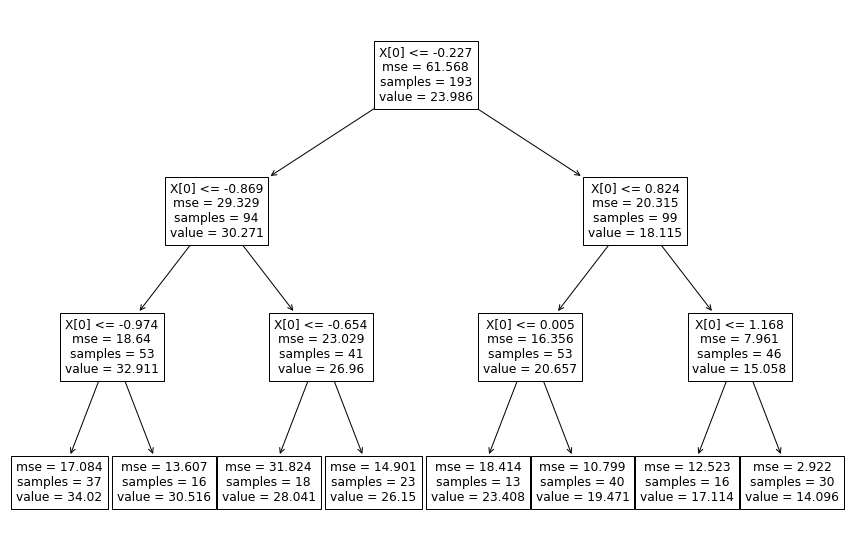

In [5]:
y_pred = lowess_reg(xtrain_scaled, ytrain, xtest_scaled, tricubic, tau = 0.02)

RFR = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=123)
RFR.fit(xtrain_scaled.reshape(-1,1), ytrain)
xtest_scaled = xtest_scaled.reshape(-1,1)
y_pred_RFR = RFR.predict(xtest_scaled)

#Showing a tree from random forest:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(15, 10))
plot_tree(RFR.estimators_[1])

Above is a visualization of a single decision tree in a random forest.

### Comparisons and Visualizations

Loess Mean-Squared-Error Was: 19.224376972979588
Random Forest Mean Squared Error Was: 15.939189673874369


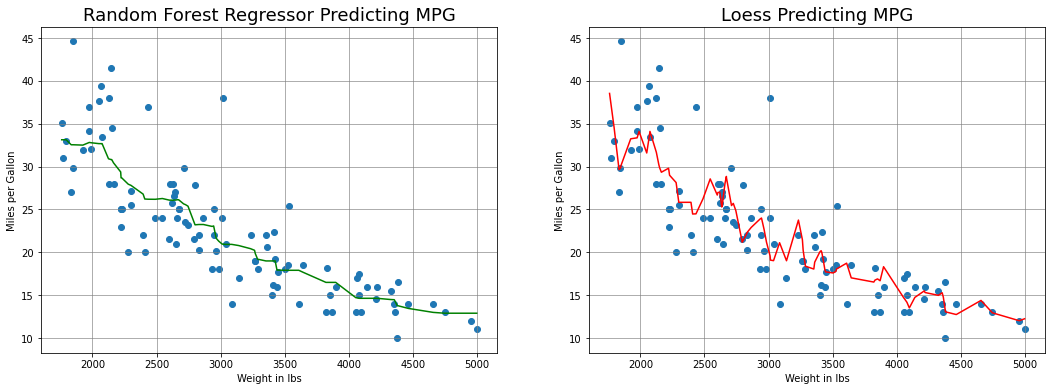

In [6]:
#Make into a full array and sort by xtest so we can interpolate in the right order
data_test_loess = np.column_stack([xtest, xtest_scaled, ytest, y_pred])
data_test_sorted_loess = data_test_loess[np.argsort(data_test_loess[:,1])]

fig, (rfr_plot, loess_plot) = plt.subplots(1,2, figsize=(18,6))
loess_plot.set_title("Loess Predicting MPG", fontsize=18)
loess_plot.set(xlabel='Weight in lbs', ylabel='Miles per Gallon')
loess_plot.scatter(data_test_sorted_loess[:,0], data_test_sorted_loess[:,2])
loess_plot.plot(data_test_sorted_loess[:,0], data_test_sorted_loess[:,3], color='red')
loess_plot.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
loess_plot.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)


data_test_rfr = np.column_stack([xtest, xtest_scaled, ytest, y_pred_RFR])
data_test_sorted_rfr = data_test_rfr[np.argsort(data_test_rfr[:,1])]

rfr_plot.set_title("Random Forest Regressor Predicting MPG", fontsize=18)
rfr_plot.set(xlabel='Weight in lbs', ylabel='Miles per Gallon')
rfr_plot.scatter(data_test_sorted_rfr[:,0], data_test_sorted_rfr[:,2])
rfr_plot.plot(data_test_sorted_rfr[:,0], data_test_sorted_rfr[:,3], color='green')
rfr_plot.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
rfr_plot.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)

loess_mse = mse(data_test_sorted_loess[:,3], data_test_sorted_loess[:,2])
rfr_mse = mse(data_test_sorted_rfr[:,2], data_test_sorted_rfr[:,3])

print("Loess Mean-Squared-Error Was: " + str(loess_mse))
print("Random Forest Mean Squared Error Was: " + str(rfr_mse))

This is an example of both regressors doing preliminary predictions for the cars dataset. In this example, the Random Forest achieves an MSE of 15.94 while Loess has a slightly higher 19.22. However, these results should not be trusted because they haven't been validated across all subsets of the data. We need to use K-Fold validation to really be sure.

## K-Fold Crossvalidation

K-fold crossvalidation is the most reliable way to validate a model's effectiveness across a dataset. It is essentially composed of splitting the data into K train-test splits while looping it all through the dataset. By making sure the model has been trained and tested independently on different subsets of the data, we can be sure of it's effectiveness (or overfitness). Here I record the MSE of each train-test split for K=10, and then graph them per model and determine the best model based on their average MSE across folds.

### Cars Data

The MSE for Random Forest is : 18.296816754411704
The MSE for Lowess is : 17.638049656558326


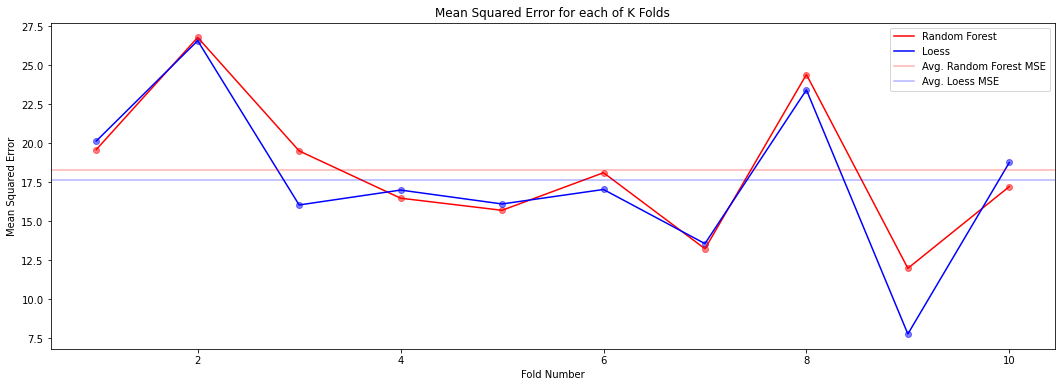

In [7]:
#Doing kfold version
data = pd.read_csv("Data/cars.csv")
x = data['WGT'].values
y = data['MPG'].values

kf = KFold(n_splits=10, shuffle=True, random_state=410)
RFR = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=410)

mse_lwr= []
mse_rfr = []

#KFold loop
for idxtrain, idxtest in kf.split(x):
    ytrain = y[idxtrain]
    xtrain = x[idxtrain]

    xtrain = scaler.fit_transform(xtrain.reshape(-1,1))
    ytest = y[idxtest]
    xtest = x[idxtest]
    xtest = scaler.transform(xtest.reshape(-1,1))
    yhat_lwr = lowess_reg(xtrain.flatten(), ytrain, xtest.flatten(), tricubic, tau=0.2)
    
    RFR.fit(xtrain,ytrain)
    yhat_rfr = RFR.predict(xtest)
    mse_lwr.append(mse(ytest, yhat_lwr))
    mse_rfr.append(mse(ytest, yhat_rfr))

xticks = np.arange(1,11)
#Plotting
fig, ax = plt.subplots(figsize=(18,6))

ax.plot(np.arange(1,11,1),mse_rfr, color='red', label='Random Forest')
ax.plot(np.arange(1,11,1),mse_lwr, color='blue', label='Loess')
ax.scatter(np.arange(1,11,1),mse_rfr, color='red', alpha=0.5)
ax.scatter(np.arange(1,11,1),mse_lwr, color='blue', alpha=0.5)
ax.axhline(y=np.mean(mse_rfr), xmin=0, xmax = 1, color='red',label='Avg. Random Forest MSE', alpha=0.3)
ax.axhline(y=np.mean(mse_lwr), xmin=0, xmax=1, color='blue', label='Avg. Loess MSE', alpha=0.3)

ax.set(xlabel='Fold Number', ylabel = 'Mean Squared Error')
ax.set_title('Mean Squared Error for each of K Folds')
ax.legend()

print('The MSE for Random Forest is : ' + str(np.mean(mse_rfr)))
print('The MSE for Lowess is : ' + str(np.mean(mse_lwr)))


### Boston Housing Data

The Mean MSE for Random Forest is : 37.08993706340423
The Mean MSE for Lowess is : 36.023070056918314


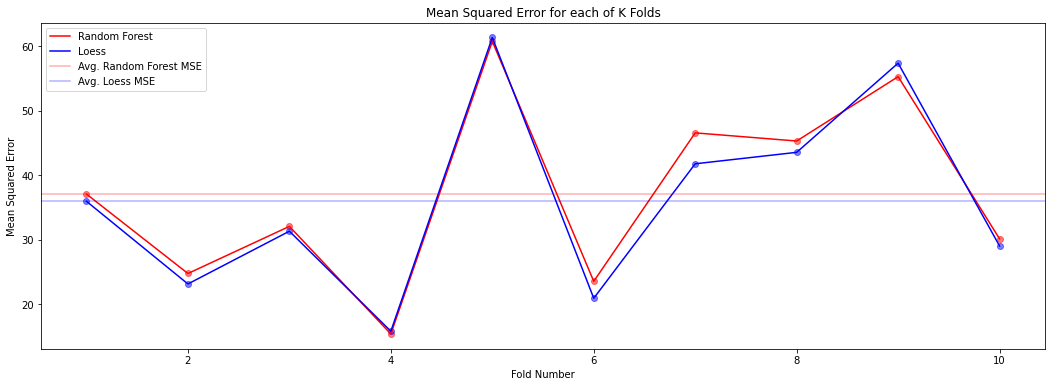

In [8]:
#Doing kfold version
data = pd.read_csv('Data/Boston_Housing_Prices.csv')
x = data['rooms'].values
y = data['cmedv'].values

kf = KFold(n_splits=10, shuffle=True, random_state=410)
RFR = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=410)

mse_lwr= []
mse_rfr = []

#KFold loop
for idxtrain, idxtest in kf.split(x):
    ytrain = y[idxtrain]
    xtrain = x[idxtrain]

    xtrain = scaler.fit_transform(xtrain.reshape(-1,1))
    ytest = y[idxtest]
    xtest = x[idxtest]
    xtest = scaler.transform(xtest.reshape(-1,1))
    yhat_lwr = lowess_reg(xtrain.flatten(), ytrain, xtest.flatten(), tricubic, tau=0.2)
    
    RFR.fit(xtrain,ytrain)
    yhat_rfr = RFR.predict(xtest)
    mse_lwr.append(mse(ytest, yhat_lwr))
    mse_rfr.append(mse(ytest, yhat_rfr))

xticks = np.arange(1,11)
#Plotting
fig, ax = plt.subplots(figsize=(18,6))

ax.plot(np.arange(1,11,1),mse_rfr, color='red', label='Random Forest')
ax.plot(np.arange(1,11,1),mse_lwr, color='blue', label='Loess')
ax.scatter(np.arange(1,11,1),mse_rfr, color='red', alpha=0.5)
ax.scatter(np.arange(1,11,1),mse_lwr, color='blue', alpha=0.5)
ax.axhline(y=np.mean(mse_rfr), xmin=0, xmax = 1, color='red',label='Avg. Random Forest MSE', alpha=0.3)
ax.axhline(y=np.mean(mse_lwr), xmin=0, xmax=1, color='blue', label='Avg. Loess MSE', alpha=0.3)

ax.set(xlabel='Fold Number', ylabel = 'Mean Squared Error')
ax.set_title('Mean Squared Error for each of K Folds')
ax.legend()

print('The Mean MSE for Random Forest is : ' + str(np.mean(mse_rfr)))
print('The Mean MSE for Lowess is : ' + str(np.mean(mse_lwr)))

### Final Results
Above are plots of the MSE scores of each model in each of the K subsets of the data. As we can see from the above validation, Loess outperformed Random Forests on both datasets. The Rendom Forest MSEs were 18.29 and 37.09 for the cars and housing datasets respectively, and the Loess MSEs were 17.64 and 36.02.

So here, Loess beats random forests. This is remarkable becuase of the Loess's relative simplicity when compared with Random Forests, but it would also be interesting to see if this performance persists with larger datasets and more features, as that is where the Random Forests strengths really are.